# Adaptive Code Generation
### Import modules

In [4]:
from llm.methods import get_sampler, extract_code
from llm.prompts.code_generation import PromptConstants, get_generic_question_template
from evaluation.compute_code_generation_metrics import check_correctness, eval_sample, eval_problems, compute_eval_results
from evaluation.code_generation import load_code_generation_dataset, Difficulty, CodeGenerationProblem

### Load the dataset
* Choose between Apps and LiveCodeBench dataset
  - Note: data types will be different as LCB generates a CodeGenerationProblem datatype

In [2]:
from datasets import load_dataset

# Load in Apps dataset of 300 sample test problems: in the order of introductory, interview, competitive
dataset = load_dataset('json', data_files='./data/apps_test_300.jsonl', split='train')

In [3]:
import json
# Load in LiveCodeBench dataset given the release version

dataset = load_code_generation_dataset(release_version="release_v5", cutoff_date="2024-05-01")
easy_problems = [problem for problem in dataset if problem.difficulty == Difficulty.EASY]
medium_problems = [problem for problem in dataset if problem.difficulty == Difficulty.MEDIUM]
hard_problems = [problem for problem in dataset if problem.difficulty == Difficulty.HARD]

print(f"Number of easy problems: {len(easy_problems)}")
print(f"Number of medium problems: {len(medium_problems)}")
print(f"Number of hard problems: {len(hard_problems)}")

Loaded 404 problems
Number of easy problems: 110
Number of medium problems: 137
Number of hard problems: 157


In [4]:
# Set to a slice for testing
start_idx = 0
end_idx = 10
if isinstance(dataset[0], CodeGenerationProblem):
    dataset = easy_problems[start_idx:end_idx] + medium_problems[start_idx:end_idx] + hard_problems[start_idx:end_idx]
    print(f"Using LiveCodeBench dataset of {len(dataset)} examples.")
else:
    dataset = dataset.select(range(start_idx, end_idx, 1))
    print(f"Using Apps dataset of {dataset.num_rows} examples.")

Using LiveCodeBench dataset of 30 examples.


### Set system prompt and sampler

In [5]:
system_prompt = PromptConstants.SYSTEM_MESSAGE_GENERIC
method = get_sampler("sample_multiple", "gpt-4o", temperature=1.3, n_samples=100, system_prompt=system_prompt)

### Code generation using sampler
Generate code and extract it from response -- might need to do some error handling there

In [6]:
# Generate prompts and responses
prompts = [get_generic_question_template(sample) for sample in dataset]
responses = method(prompts)

# Code generations as list of lists where each item within the list is a sampled generation for a prompt
code_generations = [[extract_code(response) for response in responses[i]] for i in range(len(responses))]


Processing requests: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [08:23<00:00,  5.96it/s]


## Calculate diversity of generations

In [7]:
from openai import OpenAI
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

client = OpenAI()

def generate_openai_embedding(code_samples):
    sample_embeddings = []

    # Embed all the code samples
    for sample in code_samples:
        
        # Generate embeddings
        response = client.embeddings.create(
            input=sample,
            model="text-embedding-3-small"
        )
        
        embedding = response.data[0].embedding
        sample_embeddings.append(embedding)
        
    return sample_embeddings

def generate_embeddings(code_generations):
        code_embeddings = [None] * len(code_generations)
        with ThreadPoolExecutor(max_workers=256) as executor:
            futures = []
            for i, code_samples in enumerate(code_generations):
                future = executor.submit(generate_openai_embedding, code_samples)
                futures.append((i, future))
            
            with tqdm(total=len(code_generations), desc="Processing requests") as progress_bar:
                for i, future in futures:
                    code_embeddings[i] = future.result()
                    progress_bar.update(1)
        
        return code_embeddings

In [8]:
code_embeddings = generate_embeddings(code_generations)

num_embeddings = len(code_embeddings)
print(f"Generated {num_embeddings} embeddings")

Processing requests: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:35<00:00,  5.19s/it]

Generated 30 embeddings


In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

def compute_nearest_neighbor_uniqueness(embeddings_list, threshold=0.8):
    """
    Computes uniqueness based on the nearest neighbor cosine similarity.
    
    Args:
    - embeddings (numpy.ndarray): Matrix of shape (N, D) where N is the number of items and D is embedding size.
    - threshold (float): Similarity threshold below which an item is considered unique.
    
    Returns:
    - uniqueness_score (float): Proportion of unique items in the dataset.
    - nn_similarities (numpy.ndarray): Nearest neighbor similarities for each item.
    """
    embeddings = np.array(embeddings_list)
    
    # Fit Nearest Neighbors model
    nbrs = NearestNeighbors(n_neighbors=2, metric="cosine").fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    
    # Nearest neighbor similarity (1 - cosine distance)
    nn_similarities = 1 - distances[:, 1]  # Exclude self (first neighbor is itself)
    
    # Count unique items (similarity below threshold)
    unique_items = np.sum(nn_similarities < threshold)
    
    # Normalize uniqueness score
    uniqueness_score = unique_items / len(embeddings)
    
    return uniqueness_score, nn_similarities

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def count_unique_embeddings(embeddings_list, threshold=.9):
    """
    Count unique embeddings based on cosine similarity threshold in a greedy way
    """
    embeddings = np.array(embeddings_list)
    n = len(embeddings)
    
    # Track which embeddings are already covered
    is_unique = np.ones(n, dtype=bool)
    unique_indices = []
    
    for i in range(n):
        # Skip if this embedding is already marked as a duplicate
        if not is_unique[i]:
            continue
            
        # Mark this as a unique embedding
        unique_indices.append(i)
        
        # Calculate similarity to all other embeddings
        similarities = cosine_similarity([embeddings[i]], embeddings)[0]
        
        # Mark similar embeddings as duplicates (excluding self)
        for j in range(i+1, n):
            if similarities[j] >= threshold and is_unique[j]:
                is_unique[j] = False
    
    return len(unique_indices)

def similarity_heatmap(embeddings_list, sample_size=100):
    """
    Generate heatmap based on cosine similarities
    """
    embeddings = np.array(embeddings_list)
    
    # Sample if too many embeddings
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        sample = embeddings[indices]
    else:
        sample = embeddings
        
    # Compute similarity matrix
    sim_matrix = cosine_similarity(sample)
    
    # Masking for better viewing
    sim_matrix_masked = np.copy(sim_matrix)
    mask = np.triu(np.ones_like(sim_matrix, dtype=bool), k=1)
    sim_matrix_masked[mask] = np.nan # or can use 0 but that lowkey messes up scale

    plt.figure(figsize=(10, 8))
    plt.imshow(sim_matrix_masked, cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Embedding Similarity Heatmap')
    plt.show()

48


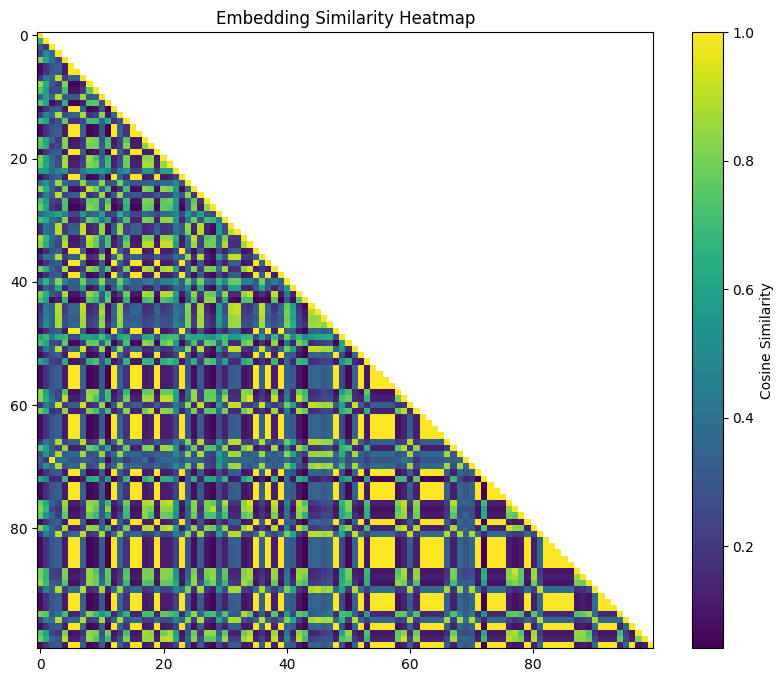

In [12]:
index = 10
unique_items = count_unique_embeddings(code_embeddings[index])
#print(code_generations[index])
print(unique_items)
similarity_heatmap(code_embeddings[index])

In [13]:
threshold = 0.90
scores = []
counts = []
for i, embedding_samples in enumerate(code_embeddings):
    score, similarities = compute_nearest_neighbor_uniqueness(embedding_samples, threshold=threshold)
    unique_items = count_unique_embeddings(embedding_samples, threshold=threshold)
    scores.append(score)
    counts.append(unique_items)
    print(f"Problem {i}: Score:{score}, Unique Samples:{unique_items}")

sample_range = len(code_embeddings) / 3
avg_easy_score = sum(scores[:10]) / sample_range
avg_easy_count = sum(counts[:10]) / sample_range

avg_med_score = sum(scores[10:20]) / sample_range
avg_med_count = sum(counts[10:20]) / sample_range

avg_hard_score = sum(scores[20:30]) / sample_range
avg_hard_count = sum(counts[20:30]) / sample_range

print(f"Easy | Score:{avg_easy_score} | Count:{avg_easy_count}")
print(f"Med | Score:{avg_med_score} | Count:{avg_med_count}")
print(f"Hard | Score:{avg_hard_score} | Count:{avg_hard_count}")
    

Problem 0: Score:0.44, Unique Samples:63
Problem 1: Score:0.24, Unique Samples:42
Problem 2: Score:0.38, Unique Samples:62
Problem 3: Score:0.13, Unique Samples:27
Problem 4: Score:0.09, Unique Samples:21
Problem 5: Score:0.41, Unique Samples:68
Problem 6: Score:0.34, Unique Samples:58
Problem 7: Score:0.39, Unique Samples:56
Problem 8: Score:0.0, Unique Samples:1
Problem 9: Score:0.0, Unique Samples:1
Problem 10: Score:0.33, Unique Samples:48
Problem 11: Score:0.43, Unique Samples:56
Problem 12: Score:0.57, Unique Samples:74
Problem 13: Score:0.44, Unique Samples:60
Problem 14: Score:0.27, Unique Samples:47
Problem 15: Score:0.35, Unique Samples:54
Problem 16: Score:0.03, Unique Samples:7
Problem 17: Score:0.02, Unique Samples:7
Problem 18: Score:0.0, Unique Samples:2
Problem 19: Score:0.09, Unique Samples:11
Problem 20: Score:0.61, Unique Samples:75
Problem 21: Score:0.71, Unique Samples:85
Problem 22: Score:0.36, Unique Samples:59
Problem 23: Score:0.64, Unique Samples:73
Problem 24

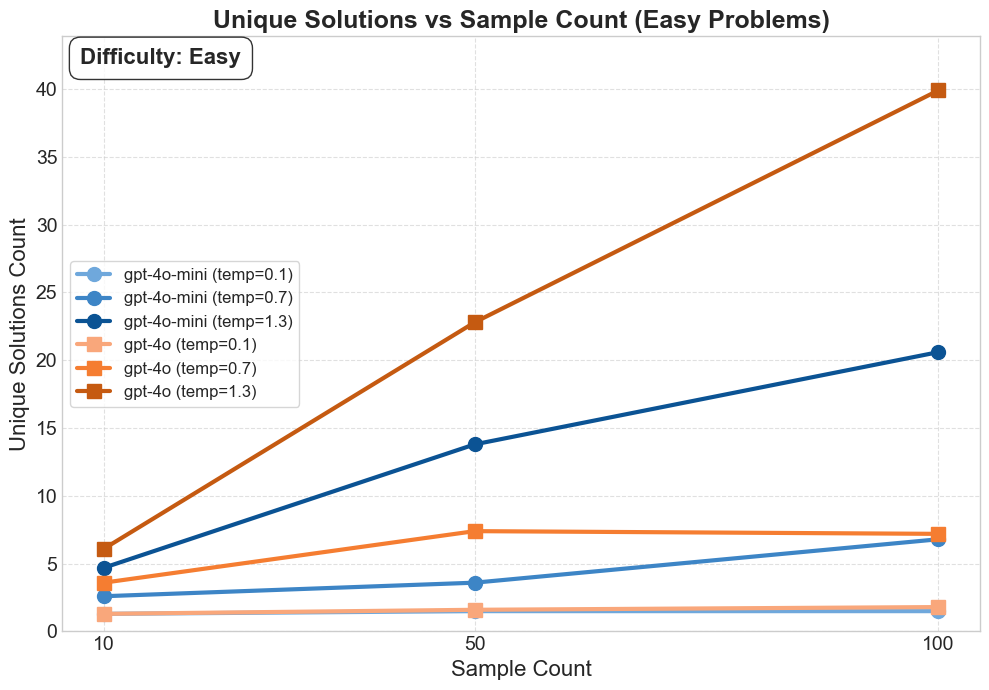

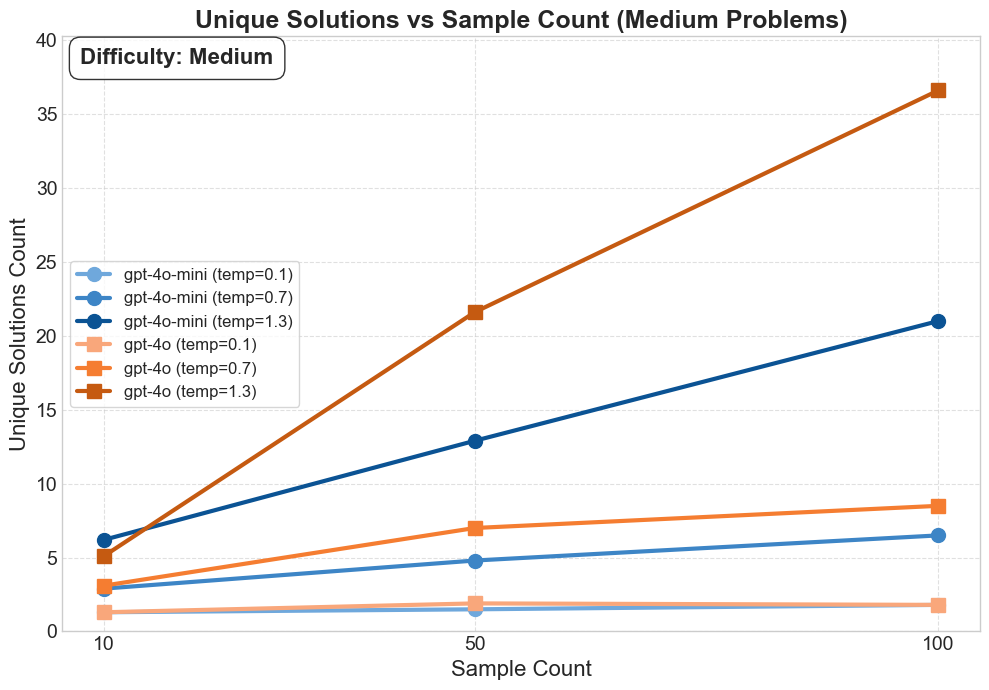

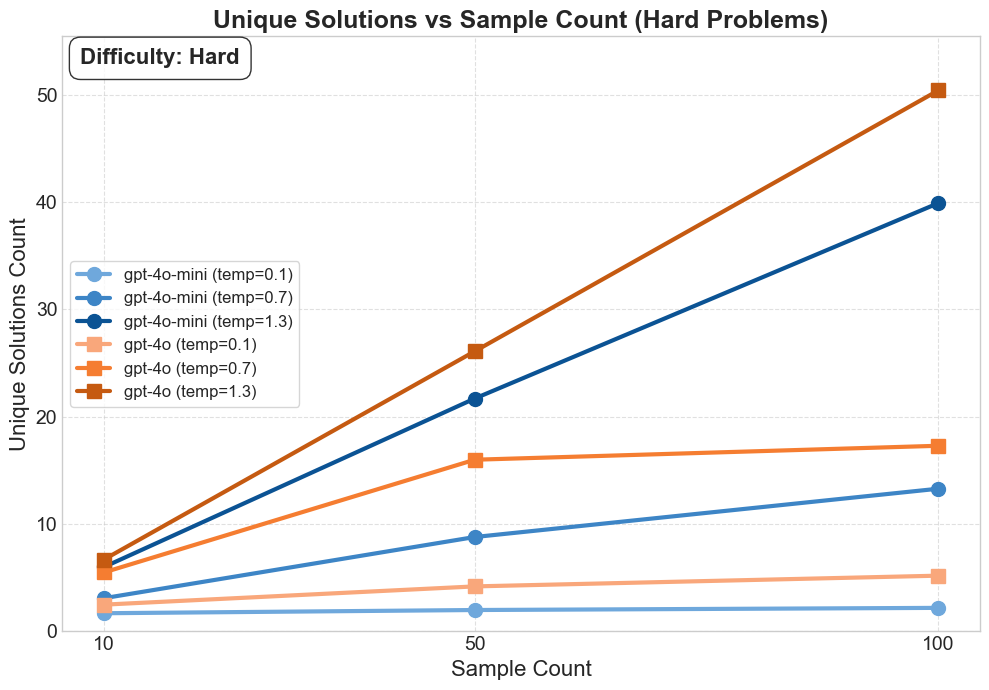

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('./experiments/diversity_clean.csv')

mini_colors = {
    0.1: '#6FA8DC', 
    0.7: '#3D85C6',  
    1.3: '#0B5394'  
}

gpt4o_colors = {
    0.1: '#F9A77B',  
    0.7: '#F57D31', 
    1.3: '#C55A11'
}

plt.rcParams['figure.dpi'] = 100  
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Roboto', 'Lato', 'DejaVu Sans']

# Create each plot based on the difficulty
def create_plot(difficulty):
    fig, ax = plt.subplots(figsize=(10, 7))
    y_max = df[difficulty].max() * 1.1  
    
    # gpt-4o-mini
    for temp in [0.1, 0.7, 1.3]:
        mini_data = df[(df['model'] == 'gpt-4o-mini') & (df['temperature'] == temp)]
        mini_data = mini_data.sort_values('count')  # Ensure data is sorted
        ax.plot(mini_data['count'], mini_data[difficulty], 
                marker='o', linestyle='-', linewidth=3, markersize=10, 
                label=f'gpt-4o-mini (temp={temp})', 
                color=mini_colors[temp])
    
    # gpt-4o
    for temp in [0.1, 0.7, 1.3]:
        gpt4o_data = df[(df['model'] == 'gpt-4o') & (df['temperature'] == temp)]
        gpt4o_data = gpt4o_data.sort_values('count')  # Ensure data is sorted
        ax.plot(gpt4o_data['count'], gpt4o_data[difficulty], 
                marker='s', linestyle='-', linewidth=3, markersize=10, 
                label=f'gpt-4o (temp={temp})', 
                color=gpt4o_colors[temp])
    
    # plot settings
    ax.set_xlabel('Sample Count', fontsize=16, fontweight='medium')
    ax.set_ylabel('Unique Solutions Count', fontsize=16, fontweight='medium')
    difficulty_title = difficulty.capitalize()
    ax.set_title(f'Unique Solutions vs Sample Count ({difficulty_title} Problems)', 
              fontsize=18, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=12, loc='best', frameon=True)
    ax.set_xticks([10, 50, 100])
    ax.set_xticklabels([10, 50, 100], fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, y_max)
    ax.text(0.02, 0.98, f"Difficulty: {difficulty_title}", 
            transform=ax.transAxes, fontsize=16, 
            fontweight='bold', va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Return the figure woo
    plt.tight_layout()
    return fig

# Plot the diversity
fig_easy = create_plot('easy')
plt.savefig('easy_solutions.png')
plt.show()

fig_medium = create_plot('medium')
plt.savefig('medium_solutions.png')
plt.show()

fig_hard = create_plot('hard')
plt.savefig('hard_solutions.png')
plt.show()

### Evaluation
Evaluate code samples in a number of ways (really all used by one another, but listed for convenience anyways):
1. check_correctness - single problem with single generation | params: sample, generation
3. eval_sample - single problem with multiple generations | params: sample, generations (list of lists)
4. eval_problems - across number of problems with various samples | params: samples, generations

In [ ]:
results = eval_problems(dataset, code_generations, timeout=4)
strict_accuracy, per_problem_accuracy = compute_eval_results(results, debug=True)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('./experiments/experiments_apps/results_new/qwen7b_results.csv')
df["Difficulty"] = ["DIFFICULTY.Introductory"] * 620 + ["DIFFICULTY.Interview"] * 620 + ["DIFFICULTY.Competition"] * 620

plt.rcParams['figure.dpi'] = 100  
plt.rcParams['font.family'] = 'sans-serif'  # Use a clean, modern font
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Roboto', 'Lato', 'DejaVu Sans']  # Modern fonts fallback list

# Get unique difficulty levels and temperatures
difficulty_levels = df["Difficulty"].unique()
temperature_levels = sorted(df["temperature"].unique())
print(temperature_levels)

temp_color_map = {
    temperature_levels[0]: "#636EFA",  # Blue
    temperature_levels[1]: "#2CA02C",  # Green
    temperature_levels[2]: "#FF7F0E",   # Orange
    temperature_levels[3]: "#8C564B",  # Purple
    temperature_levels[4]: "#D62728",   # Red
    #temperature_levels[5]: "#9803fc",
    #temperature_levels[6]: "#fc03b1",
    #temperature_levels[7]: "#400aa6",
    #temperature_levels[8]: "#2a043d"
}

#print(difficulty_levels)

for difficulty in difficulty_levels:
    plt.figure(figsize=(10, 7)) 
    subset = df[df["Difficulty"] == difficulty]
    
    # Get unique sample counts within this difficulty
    sample_counts = sorted(subset["num_samples"].unique())
    
    for temp in temperature_levels:
        if temp <= 1.3:
            temp_subset = subset[subset["temperature"] == temp]
            temp_subset = temp_subset.groupby("num_samples")["verified"].mean().reset_index()
            
            # Sort by num_samples for consistent plotting
            temp_subset = temp_subset.sort_values("num_samples")
            
            plt.plot(temp_subset["num_samples"], temp_subset["verified"], 
                     marker='o', linestyle='-', linewidth=3, markersize=10, alpha=0.85, 
                     label=f"Temp: {temp}", color=temp_color_map[temp])
    
    # Set log scale for x-axis
    #plt.xscale('log')
    plt.xticks(sample_counts, sample_counts, fontsize=14)
    plt.yticks(fontsize=14)

    #plt.xlabel("Number of Samples (Log Scale)", fontsize=16, fontweight='medium')
    plt.xlabel("Number of Samples", fontsize=16, fontweight='medium')
    plt.ylabel("Success Rate", fontsize=16, fontweight='medium')
    difficulty_label = str(difficulty)[11:]
    plt.title(f"Success Accuracy vs Sample Count ({difficulty_label})", fontsize=18, fontweight='bold')

    plt.legend(fontsize=13, loc='best', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6, which='both')  # Ensure grid aligns with log scale

    plt.show()


NameError: name 'pd' is not defined

### Serial Generation

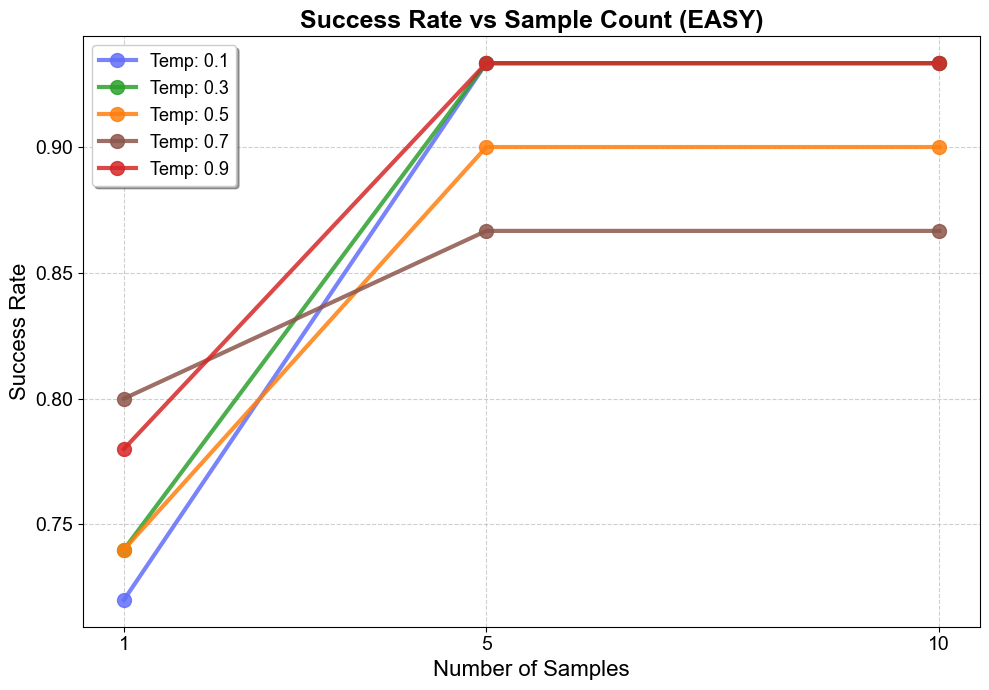

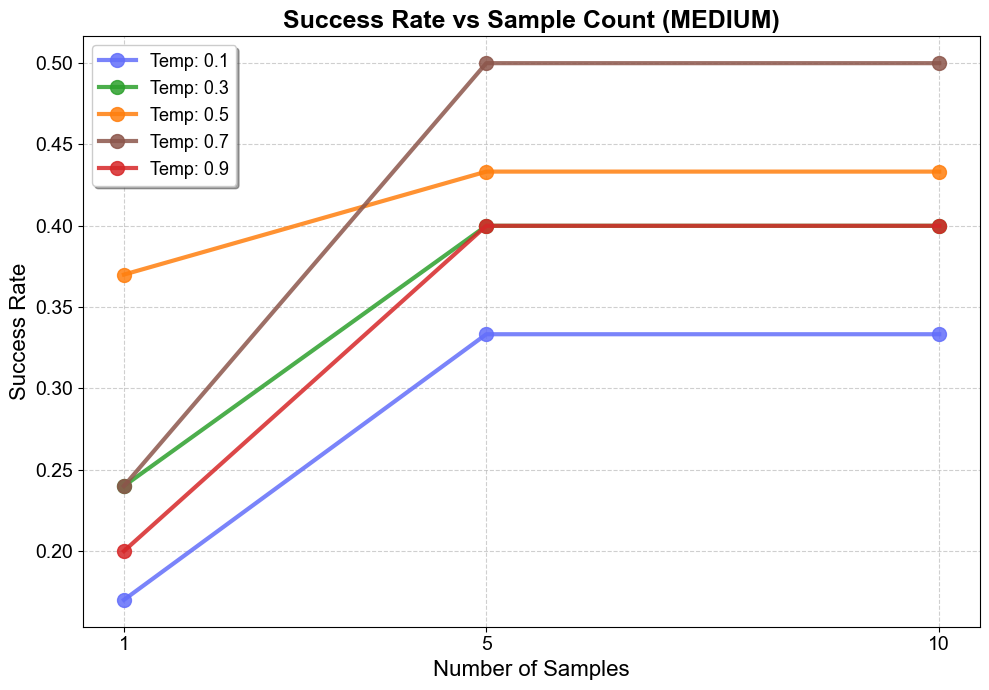

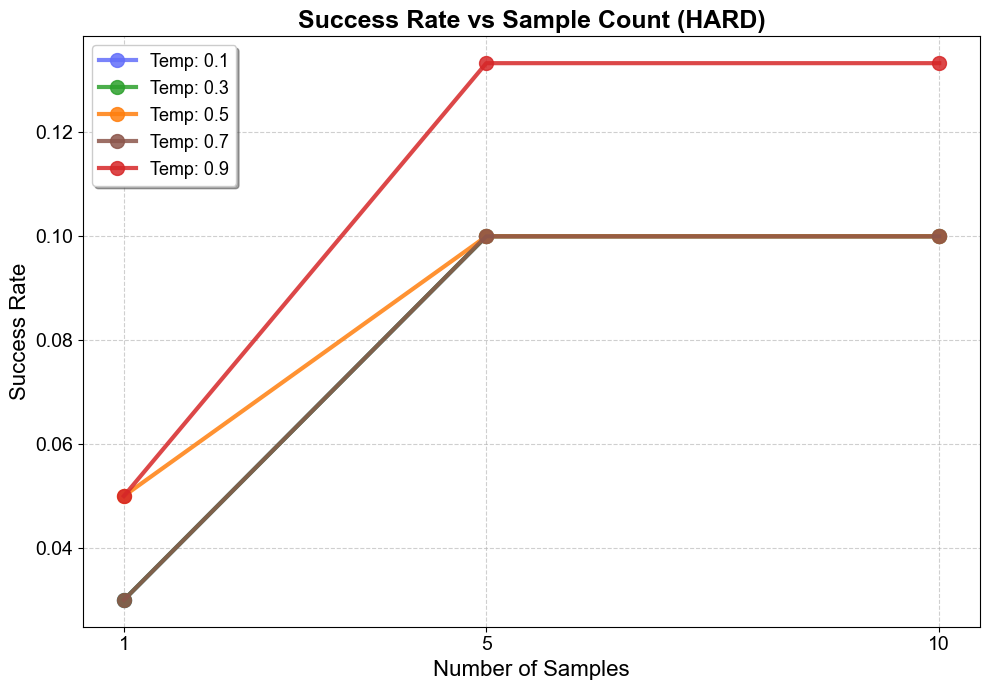

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# Function to safely parse the solutions_generated column
def parse_solutions(sol_str):
    if sol_str == '[]':
        return []
    try:
        return ast.literal_eval(sol_str)[0]  # Assuming the first list in the nested list
    except (ValueError, SyntaxError):
        return []

# Apply the parsing function
df = pd.read_csv('./experiments/serial_refinement/results.csv')
df['parsed_solutions'] = df['solutions_generated'].apply(parse_solutions)

# Function to calculate success rates for groups of solutions
def calculate_success_rates(row, n):
    solutions = row['parsed_solutions']
    if not solutions:
        return 0
    return int(any(solutions[:n]))  # Return 1 if any of the first n solutions are True

# Create columns for different group sizes
df['success_1'] = df.apply(lambda row: calculate_success_rates(row, 1), axis=1)
df['success_5'] = df.apply(lambda row: calculate_success_rates(row, 5), axis=1)
df['success_10'] = df.apply(lambda row: calculate_success_rates(row, 10), axis=1)

# Set up plotting
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Roboto', 'Lato', 'DejaVu Sans']

# Get unique difficulty levels and temperatures
difficulty_levels = df["difficulty"].unique()
temperature_levels = sorted(df["temperature"].unique())

# Create color map
temp_color_map = {
    temperature_levels[0]: "#636EFA",  # Blue
    temperature_levels[1]: "#2CA02C",  # Green
    temperature_levels[2]: "#FF7F0E",  # Orange
    temperature_levels[3]: "#8C564B",  # Brown
    temperature_levels[4]: "#D62728",  # Red
}

# Use the provided data for 1 sample count
easy_1 = [.72, .74, .74, .80, .78]
medium_1 = [.17, .24, .37, .24, .20]
hard_1 = [.03, .03, .05, .03, .05]

# Map the provided data to difficulty levels
provided_data = {
    "easy": easy_1,
    "medium": medium_1,
    "hard": hard_1
}

# Group sizes for x-axis
group_sizes = [1, 5, 10]

# Create plots for each difficulty level
for difficulty in difficulty_levels:
    plt.figure(figsize=(10, 7))
    subset = df[df["difficulty"] == difficulty]
    
    difficulty_label = difficulty.split('.')[-1] if '.' in difficulty else difficulty
    difficulty_key = difficulty_label.lower()
    
    for i, temp in enumerate(temperature_levels):
        temp_subset = subset[subset["temperature"] == temp]
        
        # Calculate success rates for each group size
        if difficulty_key in provided_data and i < len(provided_data[difficulty_key]):
            # Use provided data for 1 sample
            success_rates = [
                provided_data[difficulty_key][i],
                temp_subset['success_5'].mean(),
                temp_subset['success_10'].mean()
            ]
        else:
            success_rates = [
                temp_subset['success_1'].mean(),
                temp_subset['success_5'].mean(),
                temp_subset['success_10'].mean()
            ]
        
        plt.plot(group_sizes, success_rates,
                 marker='o', linestyle='-', linewidth=3, markersize=10, alpha=0.85,
                 label=f"Temp: {temp}", color=temp_color_map[temp])
    
    plt.xticks(group_sizes, group_sizes, fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Number of Samples", fontsize=16, fontweight='medium')
    plt.ylabel("Success Rate", fontsize=16, fontweight='medium')
    plt.title(f"Success Rate vs Sample Count ({difficulty_label})", fontsize=18, fontweight='bold')
    
    plt.legend(fontsize=13, loc='best', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

### 